## Поиск причинно-следственных связей

Импортируем нужные библиотеки

In [19]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel
import pygraphviz


# these non-covergence warnings are very annoyning, we'll disable them
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

Загрузим данные

In [2]:
dataset = pd.read_csv('./data/processed/full_data.csv')

### Препроцессинг

Здесь сделаем небольшой препроцессинг, специфический для поиска причинно-следственных связей. В частности, treatment может быть только бинарным, поэтому в основном весь препроцессинг состоит в том, чтобы преобразовать небинарный категориальный признак в бинарный (при этом теряя некоторую информацию об остальных категориях).

Задачи которые мы хотим посмотреть:

* ~~влияет ли пол на заработную плату~~,
* ~~влияет ли трудоустройство на полную ставку на зарплату~~,
* интересно, как влияет на зарплату то, что человек часто посещает StackOverflow,
* наконец, если есть степень (Ph.D.), повышает ли это шансы на более высокую зарплату?

Сначала переделаем нашу задачу в задачу классификации. Пакету DoWhy не очень нравится делать оценки для регрессии :( По крайней мере это сложнее, кроме того разброс в оцениваемых эффектах был в разы больше.

Будем считать зарплату высокой, если она больше медианной.

In [3]:
dataset['high_salary'] = dataset['ConvertedCompYearly'] > dataset['ConvertedCompYearly'].median()
dataset.drop('ConvertedCompYearly', axis=1, inplace=True)

In [4]:
dataset['frequent_visit_SO'] = dataset['SOVisitFreq'] == 'Multiple times per day'
dataset.drop('SOVisitFreq', axis=1, inplace=True)

dataset['has_phd'] = dataset['EdLevel'] == 'Other doctoral degree (Ph.D., Ed.D., etc.)'

Проверим, что все ок после нашего препроцессинга

In [5]:
assert dataset['frequent_visit_SO'].sum() != 0
# assert dataset['full_time_employed'].sum() != 0
# assert dataset['gender'].sum() != 0
assert dataset['has_phd'].sum() != 0

Сначала посмотрим на дефолтный causal graph

### Model 1. No background knowledge.

Поскольу признаков очень много, граф получается необозримым. В качестве treatment возьмем признак woman, определяющий пол человека. Наша задача -- понять, влияет ли пол на заработную плату и если да, то как.

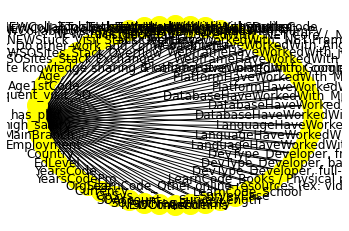

In [6]:
common_causes = [el for el in list(dataset.columns)
                 if el != 'ConvertedCompYearly' and el != 'high_salary' and el != 'has_phd'] + ['']

model=CausalModel(
        data = dataset,
        treatment='has_phd',
        outcome='high_salary',
        common_causes=common_causes)

model.view_model()

Укажем, что мы хотим оценить

In [7]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                                                                 
──────────(Expectation(high_salary|MiscTechHaveWorkedWith_.NET Core / .NET 5,WebframeHaveWorkedWith_jQuery,EdLevel,Cou
d[has_phd]                                                                                                            

                                                                                                                      
ntry,NEWStuck_Google it,LearnCode_Books / Physical media,LanguageHaveWorkedWith_HTML/CSS,WebframeHaveWorkedWith_React.
                                                                                                                      

                                                                                                                      
js,YearsCodePro,Gender,NEWCollabToolsHaveWorkedWith_Notepad++,NEWSOSi

Сделаем саму оценку

In [8]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",
                                 target_units="ate")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                                                                 
──────────(Expectation(high_salary|MiscTechHaveWorkedWith_.NET Core / .NET 5,WebframeHaveWorkedWith_jQuery,EdLevel,Cou
d[has_phd]                                                                                                            

                                                                                                                      
ntry,NEWStuck_Google it,LearnCode_Books / Physical media,LanguageHaveWorkedWith_HTML/CSS,WebframeHaveWorkedWith_React.
                                                                                                                      

                                                                                                                      
js,YearsCodePro,Gende

/home/sergeybondarev/anaconda3/envs/xai/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


Видим, что наличие степени положительно сказывается на заработной плате (что совсем не так очевидно:).

Наконец, сделаем refutation, чтобы понять насколько были верны наши предположения. Сначала попробуем random_cause.

In [9]:
# Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:-0.0005938027271475965
New effect:0.03935029291854042



/home/sergeybondarev/anaconda3/envs/xai/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


Видим, что новый эффект по модулю больше старого.

Опишем как на наш взгляд связаны признаки в данных. Для этого зададим следующий causal graph (тут взяты не все признаки, поскольку признаков очень много и граф был бы необозримым).

In [37]:
# Setting a causal graph
causal_graph = """digraph {
U[label="Unobserved Confounders"];
high_salary;
has_phd;
MainBranch;
Employment;
Country;
Ethnicity;
EdLevel;
YearsCode;
YearsCodePro;
OrgSize;
Currency;
OpSys;
Gender;
Age;
Age1stCode;
YearsCode->YearsCodePro;
Country->Currency;
EdLevel->high_salary;
YearsCode->high_salary;
Employment->YearsCode;
YearsCode->frequent_visit_SO;
YearsCodePro->frequent_visit_SO;
YearsCode->OpSys;
YearsCodePro->OpSys;
Country->Ethnicity;
Country->high_salary;
OrgSize->high_salary;
OpSys->frequent_visit_SO;
MainBranch->frequent_visit_SO;
YearsCodePro->high_salary;
Age1stCode->YearsCode;
Age->YearsCode;
Gender->MainBranch;
has_phd->EdLevel;
has_phd->Age;
frequent_visit_SO->high_salary;
Ethnicity->high_salary;
Currency->high_salary;
U->Age1stCode; U->YearsCode; U->Employment;U->high_salary;U->Gender;U->MainBranch;
}"""

In [38]:
dataset.columns

Index(['MainBranch', 'Employment', 'Country', 'EdLevel', 'YearsCode',
       'YearsCodePro', 'OrgSize', 'Currency', 'OpSys', 'SOAccount',
       'SOPartFreq', 'SOComm', 'NEWOtherComms', 'Gender', 'Ethnicity',
       'SurveyLength', 'SurveyEase', 'LearnCode_School',
       'LearnCode_Other online resources (ex: videos, blogs, etc)',
       'LearnCode_Books / Physical media', 'DevType_Developer, full-stack',
       'DevType_Developer, back-end', 'DevType_Developer, front-end',
       'LanguageHaveWorkedWith_JavaScript', 'LanguageHaveWorkedWith_HTML/CSS',
       'LanguageHaveWorkedWith_SQL', 'DatabaseHaveWorkedWith_PostgreSQL',
       'DatabaseHaveWorkedWith_MySQL',
       'DatabaseHaveWorkedWith_Microsoft SQL Server',
       'PlatformHaveWorkedWith_AWS', 'PlatformHaveWorkedWith_Microsoft Azure',
       'PlatformHaveWorkedWith_Google Cloud Platform',
       'WebframeHaveWorkedWith_React.js', 'WebframeHaveWorkedWith_jQuery',
       'WebframeHaveWorkedWith_Angular',
       'MiscTechHaveWork

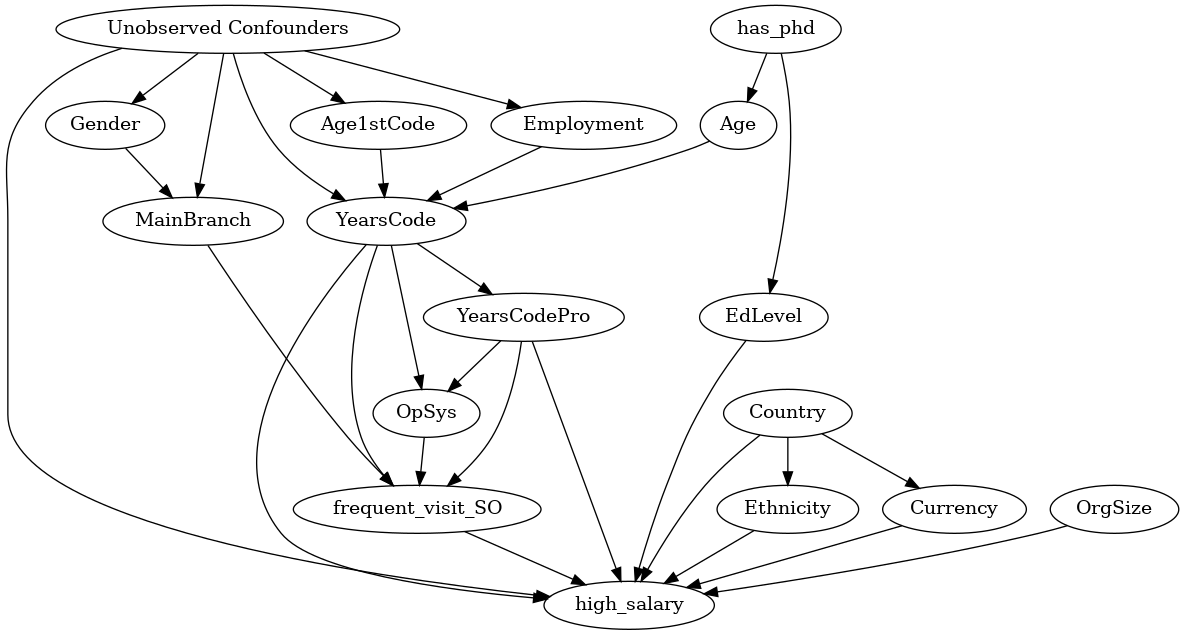

In [39]:
model=CausalModel(
        data=dataset,
        graph=causal_graph.replace('\n', ' '),
        treatment='frequent_visit_SO',
        outcome='high_salary')

model.view_model()

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [40]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                                                            
────────────────────(Expectation(high_salary|Currency,EdLevel,Age1stCode,Country,Age,YearsCodePro,Gender,OpSys,Ethnici
d[frequent_visit_SO]                                                                                                  

                                                    
ty,OrgSize,has_phd,MainBranch,YearsCode,Employment))
                                                    
Estimand assumption 1, Unconfoundedness: If U→{frequent_visit_SO} and U→high_salary then P(high_salary|frequent_visit_SO,Currency,EdLevel,Age1stCode,Country,Age,YearsCodePro,Gender,OpSys,Ethnicity,OrgSize,has_phd,MainBranch,YearsCode,Employment,U) = P(high_salary|frequent_visit_SO,Currency,EdLevel,Age1stCode,Country,Age,YearsCodePro,Gender,OpSys,Ethnicity,OrgSize,has_phd,MainBranch,Ye

In [41]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",
                                 target_units="ate")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                                                            
────────────────────(Expectation(high_salary|Currency,EdLevel,Age1stCode,Country,Age,YearsCodePro,Gender,OpSys,Ethnici
d[frequent_visit_SO]                                                                                                  

                                                    
ty,OrgSize,has_phd,MainBranch,YearsCode,Employment))
                                                    
Estimand assumption 1, Unconfoundedness: If U→{frequent_visit_SO} and U→high_salary then P(high_salary|frequent_visit_SO,Currency,EdLevel,Age1stCode,Country,Age,YearsCodePro,Gender,OpSys,Ethnicity,OrgSize,has_phd,MainBranch,YearsCode,Employment,U) = P(high_salary|frequent_visit_SO,Currency,EdLevel,Age1stCode,Country,Age,YearsCodePro,Gend

In [42]:
# Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:-0.025166445359825595
New effect:-0.024003478118986468



In [43]:
# Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(refute1_results)

Refute: Use a Placebo Treatment
Estimated effect:-0.025166445359825595
New effect:-0.0006870518900638202
p value:0.42000000000000004



In [44]:
#Creates subsets of the data(similar to cross-validation) and checks whether the 
# causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.025166445359825595
New effect:-0.02384383953830281
p value:0.25

